# Lab. 6: Bayesian Optimization

## Introduction

#### <u>The goal of this lab is to study the behavior of Bayesian optimization on a regression problem.</u>

Bayesian optimization is a probabilistic approach that uses the Bayes' Theorem $P(A|B) = \frac{P(B|A)*P(A)}{P(B)}$. Briefly, we use the prior information, P(A),(random samples) to optimize a surrogate function, P(B|A).

[Here](https://scikit-learn.org/1.2/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor.predict) you can find the "Gaussian Process Regressor" class documentation.

You'll have to implement some methods:

- *Aquisition Functions*:
  - `USB(args)` Upper Confidence Bound
  $$ \mu(x) + k \sigma(x)  $$
  - `LSB(args)` Lower Confidence Bound (for minimization only)
  $$ \mu(x) - k \sigma(x)  $$
  - `PI(args)` Probability Improvement
  $$ P(f(x) + k \sigma(x))  $$
  namely
  $$ 1-\Phi(z_0) = \Phi(-z_0) = \Phi(-\frac{f(x^*) + k - \mu(x)}{\sigma(x)}) $$
  where $\Phi$ is the normal cumulative distribution function (hint: use [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy-stats-norm)).
  - `EI(args)` Expected Improvement
  $$ EI(x) = E[f(x) - f(x_t^+)] $$
  namely
  $$ EI(x) = (\mu(x) - f(x^*) - k)\Phi(\frac{\mu(x) - f(x^*) - k}{\sigma(x)}) + \sigma(x)\varphi(\frac{f(x^*) + k - \mu(x)}{\sigma(x)}) $$
  where $\Phi$ is the normal cumulative distribution function and $\varphi$ is the probability density function (hint: use [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy-stats-norm))

- *Prior Functions*:
  - `Prior_1(objective_fun, size)` Where `X` is a random array of size `size` and `Y` is the array of `f(x)`.
  - `Prior_2(objective_fun, size)` Where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0.5, 1]` and `Y` is the array of `f(x)`.
  - `Prior_3(objective_fun, size)` Where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0, 0.5]` and `Y` is the array of `f(x)`.
- *Optimization Functions*. Here you can find some examples, feel free to use different functions:
  - `multimodal_1(x)`
  $$ \sin(x) + \sin(\frac{10}{3}x) $$
  - `multimodal_2(x)`
  $$ (1.4-3.0x) \sin(18x) $$
  - `multimodal_3(x)`
  $$ x^2 + \sin(5 \pi x)^6 $$
---

In [301]:
%%capture
!pip install scikit-optimize

In [302]:
# example of bayesian optimization for a 1d function from scratch
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import uniform
from numpy.random import random
from numpy import sin
from numpy import pi
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, ExpSineSquared
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from warnings import catch_warnings
from skopt import gp_minimize
from warnings import simplefilter

### Your first step, will be to implement the following functions:

- `acquisition_function()` implements the acquisition function
- `initial_point()` returns the initial set of points (a priori knowledge)
- `objective()` is the function to optimize.


In [303]:
def UCB(args):
  """
  Upper Confidence Bound implementation
  - args: dictionary containing arguments needed for the implementation:
    - "mu"
    - "std"
    - "best"
    - "k"

  Returns:
  - array u(X), result of acquisition function for each sample
  """
  #print(args)

  return args['mu'] +( args['k'] * args['std'])

def LCB(args):
  """
  Upper Confidence Bound implementation
  - args: dictionary containing arguments needed for the implementation:
    - "mu"
    - "std"
    - "best"
    - "k"

  Returns:
  - array u(X), result of acquisition function for each sample
  """
  return args['mu'] - args['k'] * args['std']

def PI(args):
  """
  Upper Confidence Bound implementation
  - args: dictionary containing arguments needed for the implementation:
    - "mu"
    - "std"
    - "best"
    - "k"
  
  Returns:
  - array u(X), result of acquisition function for each sample
  """
  return norm.cdf(-(args['best'] - args['mu'] + args['k'])/args['std'])

def EI(args):
  """
  Upper Confidence Bound implementation
  - args: dictionary containing arguments needed for the implementation:
    - "mu"
    - "std"
    - "best"
    - "k"

  Returns:
  - array u(X), result of acquisition function for each sample
  """
  return (args['mu']-args['best'])*norm.cdf((args['mu'] - args['best'] - args['k'])/args['std']) + args['std']*norm.pdf((args['best']+args['k']-args['mu'])/args['std'])

In [304]:

def prior_1(objective_fun, size):
  """
  Prior implementation, returns a tuple (X, Y), where `X` is a random array of size `size` and `Y` is the array of `f(x)`.
  - objective_fun: function that implements the objective function in use. Type(objective_fun) = <class 'function'>
  - size: an Integer that specifies the size of X and Y arrays

  Returns:
  - X, Y
  """
  X = random(size) 
  y = objective_fun(X)

  #print(X,y)
  return (X,y)

def prior_2(objective_fun, size):
  """
  Prior implementation, returns a tuple (X, Y), where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0.5, 1]` and `Y` is the array of `f(x)`.
  - objective_fun: function that implements the objective function in use. Type(objective_fun) = <class 'function'>
  - size: an Integer that specifies the size of X and Y arrays

  Returns:
  - X, Y
  """
  X = uniform(0.5, 1, size=size) 
  y = objective_fun(X)

  #print(X,y)
  return (X,y)

def prior_3(objective_fun, size):
  """
  Prior implementation, returns a tuple (X, Y), where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0, 0.5]` and `Y` is the array of `f(x)`.
  - objective_fun: function that implements the objective function in use. Type(objective_fun) = <class 'function'>
  - size: an Integer that specifies the size of X and Y arrays

  Returns:
  - X, Y
  """
  X = uniform(0, 0.5, size=size) 
  y = objective_fun(X)

  #print(X,y)
  return (X,y)

In [305]:
# objective function

def multimodal_1(x):
  """
  Implementation of a multimodal function
  - x: value to be evaluated

  Returns:
  - y: evaluation of x
  return math.sin(x) + math.sin((10/3) * x)

  """
  y = sin(x) + sin((10/3) * x)
  return y
  

def multimodal_2(x):
  """
  Implementation of a multimodal function
  - x: value to be evaluated

  Returns:
  - y: evaluation of x
  """
  y = 1.4 - 3.0*x * sin(18*x)
  return y

def multimodal_3(x):
  """
  Implementation of a multimodal function
  - x: value to be evaluated

  Returns:
  - y: evaluation of x
  """
  y = x**2 + (sin(5*pi*x))**6
  return y

In [306]:
def acquisition_function(function, mu, std, best, k):
  args = {"mu": mu, "std": std, "best": best, "k": k}
  result = function(args)
  return result

def initial_point(objective_fun, prior, size = 100):
  return prior(objective_fun, size)

def objective(x, objective_fun, noise=0.1):
	return objective_fun(x) + normal(loc=0, scale=noise)

In [307]:

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

def acquisition(X, Xsamples, model, function, k):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X) # here it returns an array of predicted value as the model has been fitted on X
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples) # here it returns the vectors of means and std associated to a gaussian whose more probable value is f(Xsample) because the model hasn't been fitted on Xsamples
	#extract all element from the first column of the 2-dim array mu (only for scikit-learn 1.0.2)
	#mu = mu[:, 0]
	# calculate the probability of improvement
	probs = acquisition_function(function, mu, std, best, k)
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model, size, function, k):
	# random search, generate random samples
	#print(X,y)
	#print(size)
	Xsamples = np.random.random(size)
	#print(Xsamples)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model, function, k)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model, size):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X[:size], y[:size], marker='^')
	pyplot.scatter(X[size:], y[size:])
	# line plot of surrogate function across domain5
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()


def bayesianOptmization(generation, size, function, objective_fun, prior, kernel = None, k = 0):
		# sample the domain sparsely with noise
		X , y  = initial_point(objective_fun, prior, size = size)
		# reshape into rows and cols
		X = X.reshape(len(X), 1)
		y = y.reshape(len(y), 1)
		#print(X,y)
		# define the model
		model = GaussianProcessRegressor(kernel) #you can set the kernel and the optimizer
		# fit the model
		model.fit(X, y)
		# perform the optimization process
		for i in range(generation):
				# select the next point to sample
				x = opt_acquisition(X, y, model, size, function, k)
				# sample the point
				actual = objective(x, objective_fun)
				# summarize the finding
				est, _ = surrogate(model, [[x]])
				# add the data to the dataset
				X = vstack((X, [[x]]))
				y = vstack((y, [[actual]]))
				# update the model
				model.fit(X, y)
		return X, y, model

## Exercises

### Regression
---
#### Questions:
- How does the prior knowledge change the optimization?
- How does the kernel change the optimization? (see here the [kernels](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes))
- How does the acquisition function affect the optimization?




 None


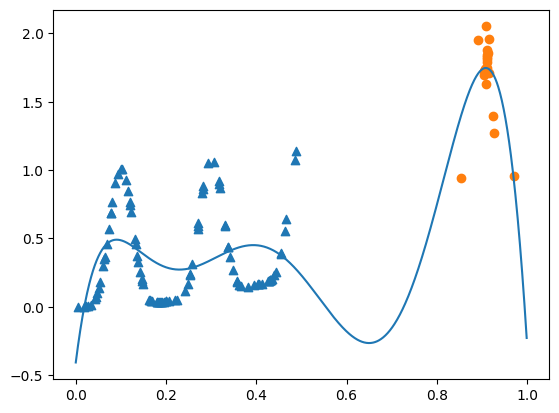

Best Result: x=0.909, y=2.050



 RBF(length_scale=0.7)


c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

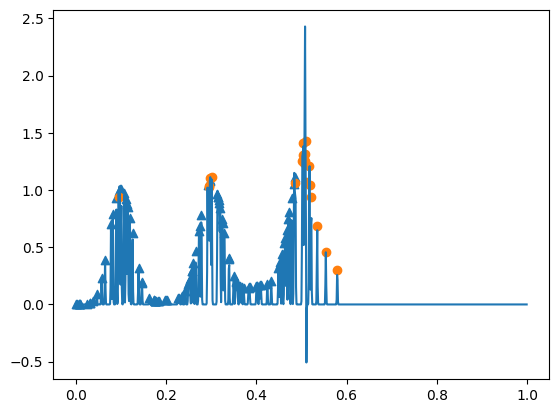

Best Result: x=0.509, y=1.424



 ExpSineSquared(length_scale=1, periodicity=1)


c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
 

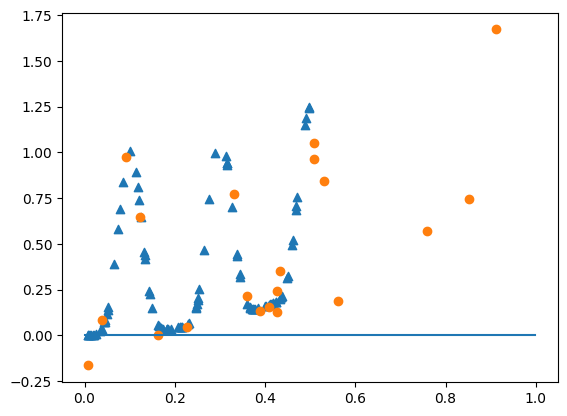

Best Result: x=0.911, y=1.671


In [331]:
size = 100
kernel_rbf = RBF(length_scale = 0.7)
kernel_expsin = ExpSineSquared(length_scale = 1)

kernels = [None, kernel_rbf, kernel_expsin]

for kernel in kernels:
    print('\n\n\n',kernel)
    X, y, model = bayesianOptmization(20, size, UCB, multimodal_3, prior_3, kernel=kernel) #TODO try with other priors, acquisition functions and objective func
    plot(X, y, model, size)
    # best result
    ix = argmax(y)
    print('Best Result: x=%.3f, y=%.3f' % (X[ix][0], y[ix][0]))

### BONUS

You can now change the acquisition functions in the regression problem, adding a slack variable `k` as a hyperparameter. How does this variable affect the optimization problem?



 0.1


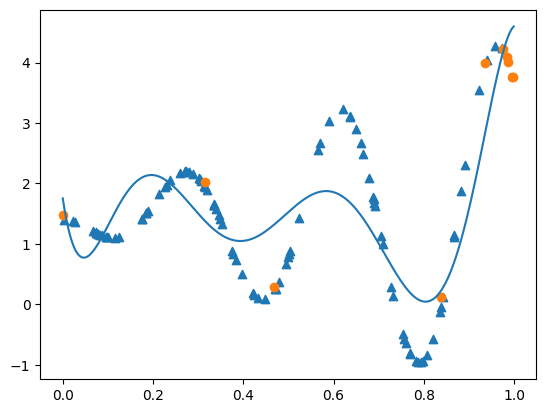

Best Result: x=0.958, y=4.272


 0.3


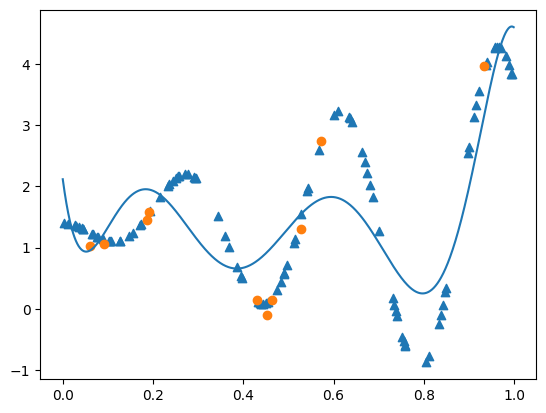

Best Result: x=0.961, y=4.283


 0.5


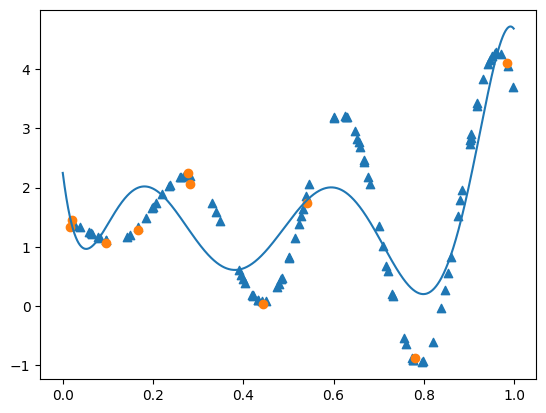

Best Result: x=0.960, y=4.281


 1


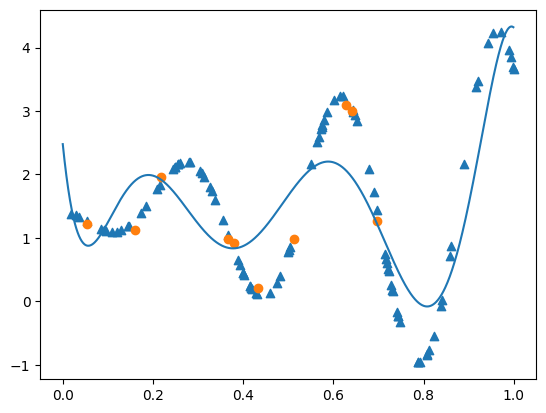

Best Result: x=0.972, y=4.247


 1.5


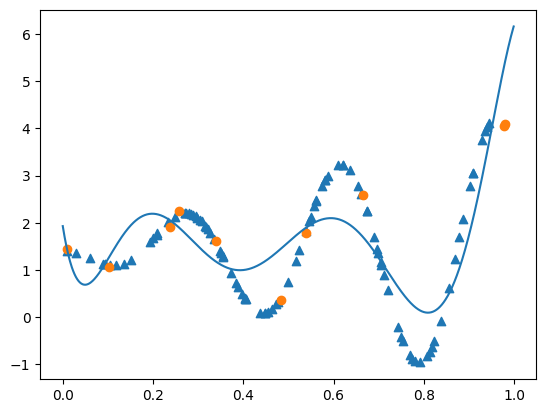

Best Result: x=0.944, y=4.117


 4


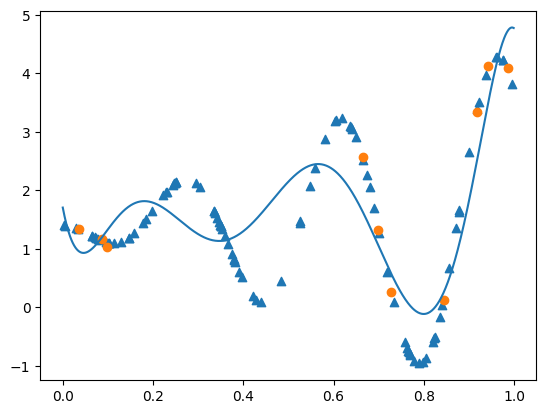

Best Result: x=0.961, y=4.283


In [316]:
size = 100
for k in [0.1, 0.3, 0.5, 1, 1.5, 4]:
    print('\n\n',k)
    X, y, model = bayesianOptmization(10, size, PI, multimodal_2, prior_1, k = k) #TODO try with other priors, acquisition functions and objective func
    plot(X, y, model, size)
    # best result
    ix = argmax(y)
    print('Best Result: x=%.3f, y=%.3f' % (X[ix][0], y[ix][0]))